### Install and Import

In [3]:
pip install tensorflow==2.11.0 opencv-python mediapipe scikit-learn matplotlib


  Using cached mediapipe-0.10.11-cp39-cp39-win_amd64.whl (50.8 MB)
  Using cached sounddevice-0.4.6-py3-none-win_amd64.whl (199 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
  Using cached jax-0.4.25-py3-none-any.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\avani\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from datetime import datetime

### Drawing Keypoints on Video Feed

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [2]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [3]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  while cap.isOpened(): #always

    ret, frame = cap.read()

    image, results = mediapipe_detection(frame, holistic)

    draw_styled_landmarks(image, results)

    cv2.imshow('OpenCV Feed', image)
    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

In [7]:
len(results.face_landmarks.landmark)

468

In [4]:
draw_landmarks(frame, results)

NameError: name 'frame' is not defined

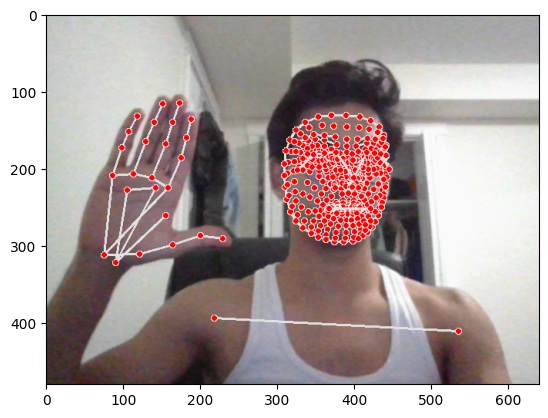

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Extracting Keypoints

In [10]:
len(results.pose_landmarks.landmark)

33

In [11]:
len(results.face_landmarks.landmark)

468

In [12]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [13]:
len(results.right_hand_landmarks.landmark)

21

In [14]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [15]:
extract_keypoints(results)[:5]

array([ 0.62401426,  0.44184691, -1.39863229,  0.99994904,  0.65114611])

### Folders for Image's NumPy Array Storage

In [18]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('dataset') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'yes', 'no'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [ ]:
# # use this if making folders for the first time


# for action in actions: 
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

In [45]:
# use this if making folders thereafter

for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    # Folder start
    start_folder = dirmax
    print(dirmax)
    temp_strg=DATA_PATH+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(temp_strg, action, str(dirmax+sequence)))
        except:
            pass

59
59
59


### Collecting Keypoints for Training

In [9]:
def make_npy_array(action):

    cap = cv2.VideoCapture(0)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        for sequence in range(start_folder, start_folder+no_sequences):
            for frame_num in range(sequence_length):

                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                    cv2.imshow('SignLearn', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                    cv2.imshow('SignLearn', image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(temp_strg, action, str(sequence+1), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                        
        cap.release()
        cv2.destroyAllWindows()

In [10]:
# for hello
make_npy_array(actions[0])

NameError: name 'start_folder' is not defined

In [52]:
# for thanks
make_npy_array(actions[1])

In [53]:
# for iloveyou
make_npy_array(actions[2])

In [ ]:
# for yes
make_npy_array(actions[3])

In [ ]:
# for no
make_npy_array(actions[4])

### Preprocessing and EDA

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2, 'yes': 3, 'no': 4}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
np.array(sequences).shape

# (no_of_videos, no_of_frames_in_each_video, no_of_keypoints_in_each_frame)

(600, 30, 1662)

In [23]:
np.array(labels).shape

# (no_of_labels) same as number of videos

(600,)

In [24]:
X = np.array(sequences)

In [25]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=77)

In [27]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(480, 30, 1662) (120, 30, 1662) (480, 5) (120, 5)


### Building the CNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout

In [29]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [30]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(30,1662,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())


In [31]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(actions.shape[0],activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 1662, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 831, 128)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 831, 64)       32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 416, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 416, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 208, 32)       0

In [32]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=10, callbacks=[tb_callback])

Epoch 1/10
15/15 [==============================] - 77s 4s/step - loss: 1.5390 - categorical_accuracy: 0.2771
Epoch 2/10
15/15 [==============================] - 63s 4s/step - loss: 1.1015 - categorical_accuracy: 0.5312
Epoch 3/10
15/15 [==============================] - 63s 4s/step - loss: 0.8459 - categorical_accuracy: 0.6521
Epoch 4/10
15/15 [==============================] - 74s 5s/step - loss: 0.6974 - categorical_accuracy: 0.7146
Epoch 5/10
15/15 [==============================] - 73s 5s/step - loss: 0.6689 - categorical_accuracy: 0.7292
Epoch 6/10
15/15 [==============================] - 69s 4s/step - loss: 0.5891 - categorical_accuracy: 0.7563
Epoch 7/10
15/15 [==============================] - 61s 4s/step - loss: 0.5060 - categorical_accuracy: 0.7896
Epoch 8/10
15/15 [==============================] - 60s 4s/step - loss: 0.5249 - categorical_accuracy: 0.7875
Epoch 9/10
15/15 [==============================] - 59s 4s/step - loss: 0.4435 - categorical_accuracy: 0.8062
Epoch 10/1

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 1662, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 831, 128)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 831, 64)       32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 416, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 416, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 208, 32)       0

 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 13,678,949
Trainable params: 13,678,949
Non-trainable params: 0
_________________________________________________________________


### Predictions

In [35]:
res = model.predict(X_test)
res

4/4 [==============================] - 3s 613ms/step


array([[4.25034763e-08, 2.04570494e-08, 1.83514192e-06, 1.63157899e-02,
        9.83682334e-01],
       [1.26149440e-02, 1.11929188e-03, 9.07959402e-01, 5.40457033e-02,
        2.42605619e-02],
       [3.81796300e-01, 5.60023636e-03, 1.82055011e-01, 4.04959857e-01,
        2.55886558e-02],
       [2.10052785e-02, 1.66604653e-01, 4.92923528e-01, 1.16351724e-01,
        2.03114778e-01],
       [1.01505127e-03, 7.97266352e-07, 1.40140161e-01, 3.60951662e-01,
        4.97892290e-01],
       [2.93046105e-05, 3.72118869e-08, 9.99931693e-01, 2.69323846e-05,
        1.20897666e-05],
       [2.60397345e-02, 5.96503960e-03, 8.39652956e-01, 1.24450348e-01,
        3.89185571e-03],
       [2.99508451e-04, 5.04704261e-08, 1.20370845e-04, 1.88444749e-01,
        8.11135292e-01],
       [4.89927109e-13, 9.99993205e-01, 6.74930652e-06, 3.82471796e-08,
        2.38799247e-09],
       [9.28674781e-05, 3.53368023e-07, 3.15506235e-02, 3.33689719e-01,
        6.34666502e-01],
       [2.59125113e-01, 9.8045

### Saving Weights

In [36]:
model.save('weights/modelWeightCNN'+str(X.shape[0])+'.h5')

### Evaluation

In [37]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [38]:
yhat = model.predict(X_test)

4/4 [==============================] - 2s 596ms/step


In [39]:
ytrue = np.argmax(y_test, axis=1).tolist()
ytrue

[4,
 2,
 3,
 4,
 3,
 2,
 3,
 3,
 1,
 3,
 2,
 2,
 1,
 4,
 1,
 2,
 4,
 1,
 2,
 3,
 1,
 0,
 2,
 1,
 4,
 1,
 2,
 4,
 4,
 0,
 1,
 2,
 0,
 3,
 4,
 4,
 0,
 3,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 0,
 0,
 4,
 3,
 4,
 3,
 0,
 4,
 1,
 2,
 0,
 2,
 4,
 1,
 0,
 2,
 3,
 4,
 0,
 0,
 2,
 4,
 2,
 3,
 1,
 0,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 1,
 4,
 0,
 4,
 4,
 3,
 1,
 4,
 2,
 2,
 1,
 1,
 4,
 2,
 1,
 4,
 4,
 0,
 3,
 0,
 1,
 1,
 4,
 1,
 0,
 0,
 3,
 2,
 1,
 4,
 1,
 0,
 0,
 0,
 0,
 4,
 4,
 3,
 1,
 2,
 3,
 3]

In [40]:
yhat = np.argmax(yhat, axis=1).tolist()
yhat

[4,
 2,
 3,
 2,
 4,
 2,
 2,
 4,
 1,
 4,
 2,
 2,
 1,
 4,
 1,
 0,
 4,
 1,
 2,
 4,
 1,
 0,
 2,
 1,
 3,
 1,
 2,
 4,
 4,
 0,
 1,
 0,
 2,
 3,
 4,
 4,
 0,
 4,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 4,
 4,
 4,
 0,
 0,
 4,
 1,
 2,
 0,
 2,
 4,
 1,
 0,
 2,
 4,
 4,
 0,
 0,
 2,
 0,
 2,
 4,
 1,
 0,
 3,
 0,
 0,
 4,
 0,
 4,
 2,
 1,
 2,
 0,
 4,
 4,
 3,
 1,
 0,
 2,
 2,
 1,
 1,
 4,
 2,
 1,
 4,
 4,
 0,
 3,
 0,
 1,
 1,
 4,
 1,
 0,
 0,
 4,
 2,
 1,
 4,
 2,
 0,
 0,
 2,
 0,
 2,
 4,
 4,
 1,
 2,
 2,
 4]

In [41]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[89,  8],
        [ 2, 21]],

       [[97,  0],
        [ 1, 22]],

       [[87,  9],
        [ 3, 21]],

       [[95,  1],
        [19,  5]],

       [[81, 13],
        [ 6, 20]]], dtype=int64)

In [42]:
accuracy_score(ytrue, yhat)

0.7416666666666667

### Real-Time

In [43]:
from scipy import stats

In [51]:
def prob_and_feedback(res, actions, input_frame):
    output_frame = input_frame.copy()

    # Get indices of top 2 probabilities
    top_idx = res.argsort()[-2:][::-1]

    # Display message asking user to choose between the top 2 actions
    cv2.rectangle(output_frame, (0, output_frame.shape[0] - 45), (output_frame.shape[1], output_frame.shape[0]), (0, 0, 0), -1)
    cv2.putText(output_frame, f"Did you mean {actions[top_idx[0]]} ({res[top_idx[0]]*100:.0f}%) or {actions[top_idx[1]]} ({res[top_idx[1]]*100:.0f}%)?", (10, output_frame.shape[0] - 18), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    # Open a new window and show the image corresponding to the action with the second highest probability
    img_path = os.path.join("images", f"{actions[top_idx[1]]}.png")
    img = cv2.imread(img_path)
    img = cv2.resize(img, (500, 310))  # Resize the image

    cv2.rectangle(img, (0, img.shape[0] - 45), (img.shape[1], img.shape[0]), (0, 0, 0), -1)
    cv2.putText(img, f" Correct Way to Act: {actions[top_idx[1]]}", (0, img.shape[0] - 18), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)  # Add text to the image
    cv2.imshow("Suggested Action", img)

    return output_frame

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
       
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_and_feedback(res, actions, image)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('SignLearn', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()